# 3D-Var for Lorenz63 System

We analyze the Lorenz63 system of nonlinear ODEs

$$
\begin{align}
	 \frac{\mathrm{d} x}{\mathrm{d} t} &= -\sigma(x-y), \nonumber  \\
	\frac{\mathrm{d} y}{\mathrm{d} t}  &= \rho x-y-xz,  \label{eq:lorenz} \\
	\frac{\mathrm{d} z}{\mathrm{d} t}  &= xy -\beta z,   \nonumber
\end{align}
$$

where $x=x(t),$ $y=y(t)$, $z=z(t)$ and $\sigma$ (ratio of kinematic viscosity divided by thermal diffusivity),
$\rho$ (measure of stability) and  $\beta$ (related to the wave number) are parameters. Chaotic behavior is obtained when the parameters are chosen as

$$
  \sigma = 10,\quad \rho=28,\quad \beta = 8/3.
$$

This system is a simplified model for atmospheric convection and is an excellent example of the lack of predictability. It is ill-posed  in the sense of Hadamard.


## Problem setup

We set up a twin experiment with the following parameters:

- true initial condition $u_t (0) = [1,1,1]^T $ and initial guess $u (0) = [2,3,4]^T $ 
- observations every $0.2$ time units, for a duration of $2$ units
- complete measurement of system state, i.e.  $H(u)=u.$
- measurement noise is Gaussian, zero mean, equal variances $\sigma = \sigma_1 = \sigma_2 = \sigma_3 = 0.15$ and hence $R= \mathrm{diag} (\sigma)$
- fixed background covariance matrix $B = \mathrm{diag} (0.01,\ 0.01,\ 0.01)$

### Procedure

1. Background state values are computed at $t = 0.2$ by time integration of the L63 system, starting from the initial guess. 
2. Observations at $t = 0.2$ are assimilated to provide the analysis at $t = 0.2. $
3. After that, background state values are computed at $t = 0.4$ by time integration, starting from the analysis at $t = 0.2,$ and so on.

The prediction is made up to time $t=10.$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from examples import *
from time_integrators import *

def Lin3dvar(ub,w,H,R,B,opt):
    
    # The solution of the 3DVAR problem in the linear case requires 
    # the solution of a linear system of equations.
    # Here we utilize the built-in numpy function to do this.
    # Other schemes can be used, instead.
    
    if opt == 1: #model-space approach
        Bi = np.linalg.inv(B)
        Ri = np.linalg.inv(R)
        A = Bi + (H.T)@Ri@H
        b = Bi@ub + (H.T)@Ri@w
        ua = np.linalg.solve(A,b) #solve a linear system 
    
    elif opt == 2: #model-space incremental approach
        
        Bi = np.linalg.inv(B)
        Ri = np.linalg.inv(R)
        A = Bi + (H.T)@Ri@H
        b = (H.T)@Ri@(w-H@ub)
        ua = ub + np.linalg.solve(A,b) #solve a linear system 
        
        
    elif opt == 3: #observation-space incremental approach
    
        A = R + H@B@(H.T)
        b = (w-H@ub)
        ua = ub + B@(H.T)@np.linalg.solve(A,b) #solve a linear system
        
    return ua

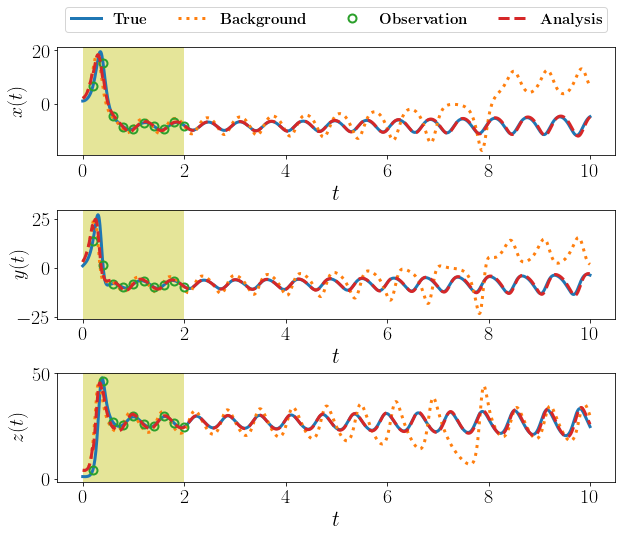

In [5]:
#Application: Lorenz 63
# parameters
sigma = 10.0     
beta = 8.0/3.0
rho = 28.0     
dt = 0.01
tm = 10
nt = int(tm/dt)
t = np.linspace(0,tm,nt+1)

############################ Twin experiment ##################################

u0True = np.array([1,1,1]) # True initial conditions
np.random.seed(seed=1)
sig_m= 0.15  # standard deviation for measurement noise
R = sig_m**2*np.eye(3) #covariance matrix for measurement noise
H = np.eye(3) #linear observation operator

dt_m = 0.2 #time period between observations
tm_m = 2 #maximum time for observations
nt_m = int(tm_m/dt_m) #number of observation instants

#t_m = np.linspace(dt_m,tm_m,nt_m) #np.where( (t<=2) & (t%0.1==0) )[0]
ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int)
t_m = t[ind_m]

#time integration
uTrue = np.zeros([3,nt+1])
uTrue[:,0] = u0True
km = 0
w = np.zeros([3,nt_m])
for k in range(nt):
    uTrue[:,k+1] = RK4(Lorenz63,uTrue[:,k],dt,sigma,beta,rho)
    if (km<nt_m) and (k+1==ind_m[km]):
        w[:,km] = H@uTrue[:,k+1] + np.random.normal(0,sig_m,[3,])
        km = km+1

        
########################### Data Assimilation #################################

u0b = np.array([2.0,3.0,4.0])

sig_b= 0.1
B = sig_b**2*np.eye(3)

#time integration
ub = np.zeros([3,nt+1])
ub[:,0] = u0b
ua = np.zeros([3,nt+1])
ua[:,0] = u0b
km = 0
for k in range(nt):
    ub[:,k+1] = RK4(Lorenz63,ub[:,k],dt,sigma,beta,rho)
    ua[:,k+1] = RK4(Lorenz63,ua[:,k],dt,sigma,beta,rho)

    if (km<nt_m) and (k+1==ind_m[km]):
        ua[:,k+1] = Lin3dvar(ua[:,k+1],w[:,km],H,R,B,3)  
        km = km+1


############################### Plotting ######################################

import matplotlib as mpl
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 20}
#mpl.rc('font', **font)

fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(10,8))
ax = ax.flat

for k in range(3):
    ax[k].plot(t,uTrue[k,:], label=r'\bf{True}', linewidth = 3)
    ax[k].plot(t,ub[k,:], ':', label=r'\bf{Background}', linewidth = 3)
    ax[k].plot(t[ind_m],w[k,:], 'o', fillstyle='none', \
               label=r'\bf{Observation}', markersize = 8, markeredgewidth = 2)
    ax[k].plot(t,ua[k,:], '--', label=r'\bf{Analysis}', linewidth = 3)
    ax[k].set_xlabel(r'$t$',fontsize=22)
    ax[k].axvspan(0, tm_m, color='y', alpha=0.4, lw=0)

ax[0].legend(loc="center", bbox_to_anchor=(0.5,1.25),ncol =4,fontsize=15)

ax[0].set_ylabel(r'$x(t)$', labelpad=5)
ax[1].set_ylabel(r'$y(t)$', labelpad=-12)
ax[2].set_ylabel(r'$z(t)$')
fig.subplots_adjust(hspace=0.5)

#plt.savefig('L63_3DVAR.png', dpi = 500, bbox_inches = 'tight')



## Conclusions

The 3D-Var does a reasonably good job. The forecast is quite accurate up to time $t=10.$